# <center> <b> <font color='blue'> ELECTRICAL PRODUCTION </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Models](#5)
6. [Comparing results](#6)
7. [Hyperparameter Tuning](#7)
8. [References](#References)

<a name="1"></a>
## <font color='#2e86c1'> <b> 1. Problem Statement </font> </b>

We're gonna predict the electrical production. It is a time series problem.

<a name="2"></a>
## <font color='#2e86c1'> <b> 2. Setup </font> </b>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [206]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import pandas as pd
from tensorflow.keras import layers
import keras_tuner as kt
import keras_tuner
from keras import backend as K

In [188]:
tf.get_logger().setLevel('ERROR')

<a name="3"></a>
## <font color='#2e86c1'> <b> 3. Helper Functions </font> </b>

### Ploting

In [137]:
def plot_series(time, series, title, xlabel, ylabel, format="-", start=0, end=None, color='blue'):
    plt.plot(time[start:end], series[start:end], format, color=color)

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])
    
    # Set title with bold and colored text
    plt.title(title, fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'darkred'})
    
    # Set xlabel with bold and colored text
    plt.xlabel(xlabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    # Set ylabel with bold and colored text
    plt.ylabel(ylabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    plt.grid(True)
    plt.show()  # Show the plot if desired

    

def plot_train_val(time_train, series_train, time_valid, series_valid):
    plt.figure(figsize=(12, 6))
    plt.plot(time_train, series_train, label='Training Set', color='blue')
    plt.plot(time_valid, series_valid, label='Validation Set', color='orange')

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])

    # Adding titles and labels
    plt.title('Training and Validation Sets')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.axvline(x=time_train[-1], color='red', linestyle='--', label='Split Point')  # Optional: Split line
    plt.legend()
    plt.grid()
    plt.show()
    

    
def plot_history(history):
    # Assuming `history` is the output from model.fit()
    # Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation MSE
    plt.subplot(1, 2, 2)  # One row, two columns, second subplot
    plt.plot(history.history['mse'], label='Training MSE')
    if 'val_mse' in history.history:
        plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    
    
    
def plot_comparison(time, true_values, preds):
    plt.figure(figsize=(10, 5))  # Optional: Set the figure size
    plt.plot(time, preds, label='Preds', color='blue')  # Plot the first array
    plt.plot(time, true_values, label='True', color='orange')  # Plot the second array

    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Series')
    plt.title('True vs pred')
    plt.legend()  # Show legend
    plt.grid(True)  # Optional: Add a grid


    # Set x-ticks to show only specific labels
    plt.xticks(np.arange(0, 100, 50))  # Show ticks from 0 to 10 with a step of 1

    # Show the plot
    plt.show()
    
    
def plot_model_metrics(results):
    # Extract data
    models = list(results.keys())
    metrics = list(results[models[0]].keys())
    values = {metric: [] for metric in metrics}

    for model in models:
        for metric in metrics:
            values[metric].append(results[model][metric])

    x = np.arange(len(models))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each metric
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, values[metric], width, label=metric)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models', fontweight='bold')
    ax.set_ylabel('Value', fontweight='bold')
    ax.set_title('Comparison of Models by Metrics', fontweight='bold', color='#12222C')
    ax.set_xticks(x + width * (len(metrics) / 2 - 0.5))
    ax.set_xticklabels(models)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

### Train/test split

In [ ]:
# train/test split
def train_val_split(time, series, split_size):
    """
    Split the time series data into training and validation sets.
    We do not shuffle the data because is a time series problem.

    Parameters:
    - time (list-like): List or array containing the time index of the time series.
    - series (list-like): List or array containing the values of the time series.
    - split_size (float): The proportion of data to be allocated for training.
                          Value should be between 0 and 1.

    Returns:
    - time_train (list-like): Time index of the training set.
    - series_train (list-like): Values of the training set.
    - time_valid (list-like): Time index of the validation set.
    - series_valid (list-like): Values of the validation set.

    Example:
        If time = [1, 2, 3, 4, 5] and series = [10, 20, 30, 40, 50],
            and split_size = 0.8, then the function returns:
                time_train = [1, 2, 3]
                series_train = [10, 20, 30]
                time_valid = [4, 5]
                series_valid = [40, 50]
    """
    
    # índice de la divisón
    training_size = int(len(time)*split_size)

    time_train = time[:training_size]
    series_train = series[:training_size]
    time_valid = time[training_size:]
    series_valid = series[training_size:]

    return time_train, series_train, time_valid, series_valid

### Windowing

In [23]:
def windowed_dataset(series, 
                     window_size=G.WINDOW_SIZE, 
                     horizon=G.HORIZON, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    """
    Create a windowed dataset for time series prediction.

    Parameters:
    - series: 1D array-like structure containing the time series data.
    - window_size: Size of the window for features.
    - horizon: 
    - batch_size: Number of samples per batch.
    - shuffle_buffer: Size of the shuffle buffer.
    - shuffle: Boolean indicating whether to shuffle the dataset.

    Returns:
    - A TensorFlow dataset of input-output pairs.
    """
    
    if window_size <= 0 or batch_size <= 0:
        raise ValueError("window_size and batch_size must be greater than 0")
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    # w[:-horizon]: all but the last 'horizon' elements for features
    # w[-horizon:]: the last 'horizon' elements for labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))  # Use -horizon for labels
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Predictions

In [6]:
def forecast(model, initial_window, num_predictions, horizon=1):
    """
    Forecast future values using a model with multi-step horizon predictions.
    
    Args:
        model: The trained model used for predictions.
        initial_window: The starting data window.
        num_predictions: The total number of steps to predict.
        horizon: The number of steps the model predicts in each iteration (e.g., 2 for 2 steps ahead).
        verbose: If True, prints details about the current window and predictions.
        
    Returns:
        A NumPy array of predicted values.
    """
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for multiple steps ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_steps = pred[0][:horizon]  # Extract the predicted steps

        # Add the predictions to the list, but ensure we don't exceed num_predictions
        steps_to_add = min(horizon, num_predictions - len(predictions))
        predictions.extend(pred_steps[:steps_to_add])

        # Update the window: remove the oldest values and add the new predictions
        current_window = np.roll(current_window, -steps_to_add)  # Shift left by the number of steps added
        current_window[-steps_to_add:] = pred_steps[:steps_to_add]  # Insert the new predictions at the end

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


### Calculate metrics and store results

In [26]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
 
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}


def store_results(results, name, data):
    
    # Store the data in the results dictionary
    results[name] = data
    
    return results

<a name="4"></a>
## <font color='#2e86c1'> <b> 4. Loading and pre-processing data </font> </b>

This project uses the [Electric Production](https://www.kaggle.com/datasets/shenba/electricity-production) dataset by Kaggle.

### Loading data

In [7]:
!cd data && ls

Electric_Production.csv


In [8]:
data = pd.read_csv('data/Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


### Exploration

In [9]:
data.shape

(397, 2)

In [10]:
data.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [12]:
data.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values.

In [13]:
times = data['DATE']
consumption = data['IPG2211A2N']

In [71]:
# Class for storing data
@dataclass
class G:
    #TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    #times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = times.values
    SERIES = consumption.values
    SPLIT_TIME = 250
    WINDOW_SIZE = 7
    HORIZON = 1
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8

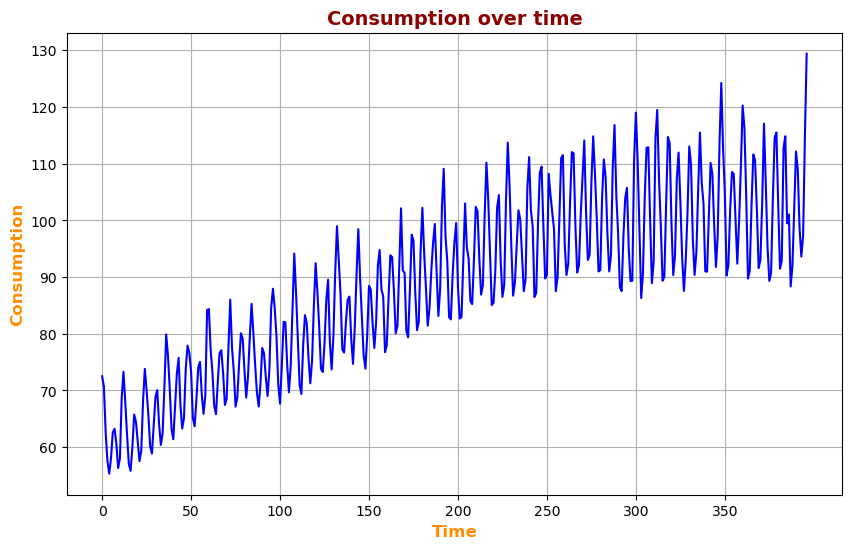

In [15]:
# plot time series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, 'Consumption over time', 'Time', 'Consumption')
plt.show()

We can see a growing trend.

### Train/Test split

In [16]:
len(G.TIME)

397

In [17]:
int(len(G.TIME)*G.SPLIT_SIZE)

317

In [141]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_SIZE)

In [142]:
time_train.shape, series_train.shape, time_valid.shape, series_valid.shape

((317,), (317,), (80,), (80,))

Let's plot our sets.

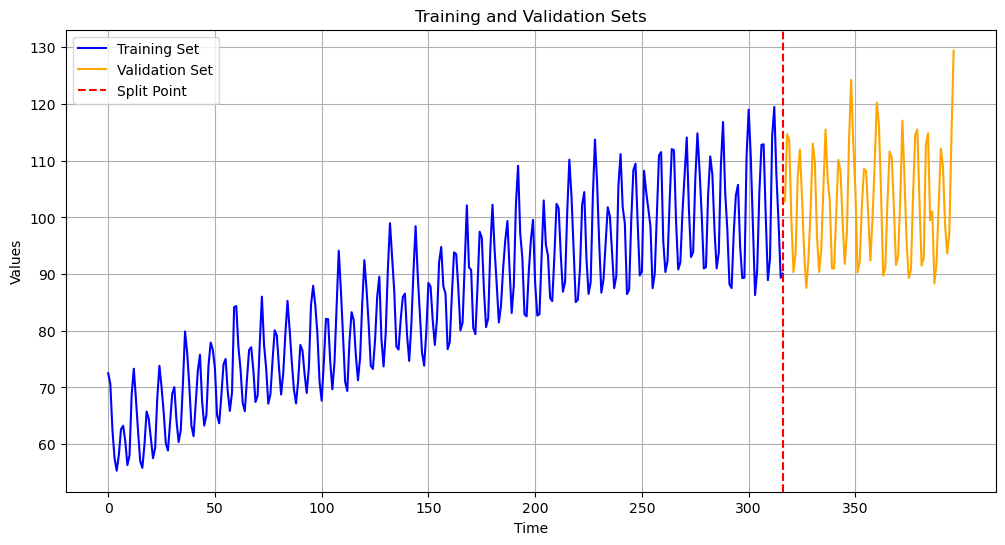

In [22]:
plot_train_val(time_train, series_train, time_valid, series_valid)

### Windowing the dataset

In [24]:
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, 
                             batch_size=G.BATCH_SIZE)

In [25]:
# Apply to the validation set; NO shuffle
val_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, 
                           batch_size=G.BATCH_SIZE,shuffle=False)

<a name="5"></a>
## <font color='#1a5276'> <b> 5. Models </font> </b>

In [27]:
tf.random.set_seed(42)

results = {}

<a name="5.0"></a>
### <font color='#2874a6'> <b> 5.0. Baseline </font> </b>

In [95]:
aux = G.SERIES[:-81]
len(aux), len(G.SERIES)

(316, 397)

In [106]:
# naive forecast
naive_forecast = G.SERIES[-len(series_valid)-1:-1]

naive_forecast.shape


(80,)

In [107]:
naive_results = evaluate_preds(y_true=series_valid,
                               y_pred=naive_forecast)

In [108]:
naive_results

{'mae': 8.326281, 'mse': 90.36039, 'rmse': 9.505808, 'mape': 8.093309}

In [109]:
store_results(results, 'Naive Forecast', naive_results)

{'Naive Forecast': {'mae': 8.326281,
  'mse': 90.36039,
  'rmse': 9.505808,
  'mape': 8.093309},
 'Model 1 (Simple Dense)': {'mae': 8.078486,
  'mse': 105.33032,
  'rmse': 10.263056,
  'mape': 8.246225}}

In [110]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(series_valid).numpy()

102.71854125

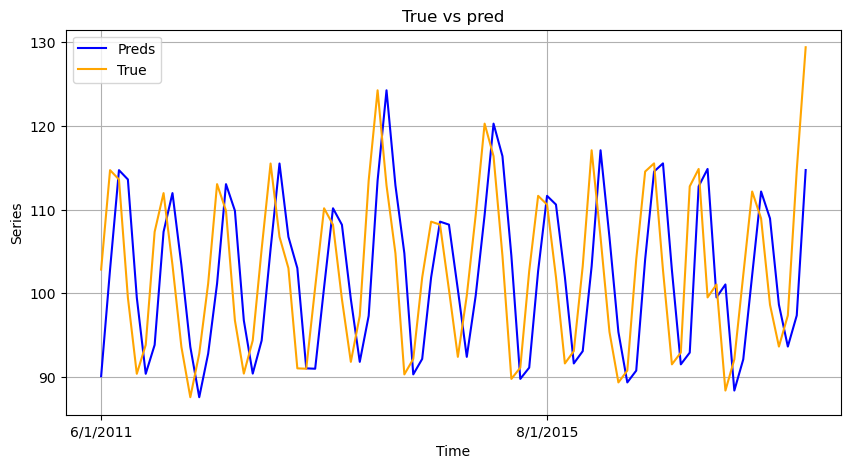

In [111]:
plot_comparison(time_valid, series_valid, naive_forecast)

<a name="5.1"></a>
### <font color='#2874a6'> <b> 5.1. Simple Dense Model </font> </b>

<img src="images/model1.png"/>

In [35]:
def build_compile_model_one(name, horizon=G.HORIZON, window_size=G.WINDOW_SIZE, num_features=1):
    # Construct model
    model = tf.keras.models.Sequential([
      #layers.InputLayer(input_shape=(window_size, num_features)),  # Explicit input layer
      layers.InputLayer(input_shape=[window_size]),
      layers.Dense(128,activation='relu'),
      layers.Dense(horizon, activation="linear")                 
    ], name=name)

    # Compile model
    model.compile(loss="mse",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mse"])
    
    return model


model_1 = build_compile_model_one('Simple_Dense')
model_1.summary()

Model: "Simple_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1024      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Fit the model
history_one = model_1.fit(
            train_set,
            epochs=100,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

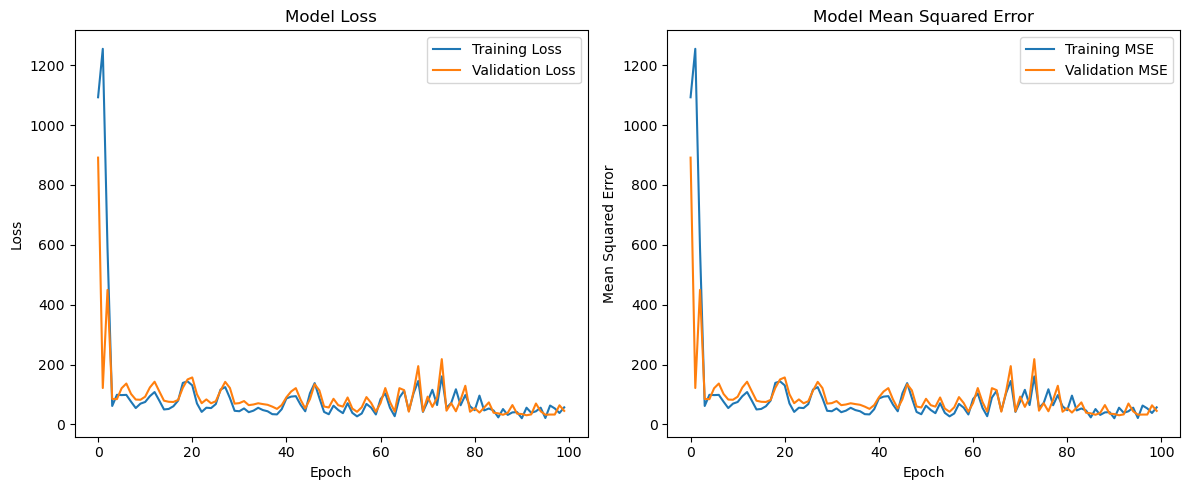

In [138]:
plot_history(history_one)

Now we are going to calculate the predictions. Our initial window will consist of the last 'window size' elements from the training set.

In [39]:
series_train[-G.WINDOW_SIZE:]

array([ 92.775 , 114.3266, 119.488 , 107.3753,  99.1028,  89.3583,
        90.0698])

In [44]:
preds_model_1 = forecast(model_1, series_train[-G.WINDOW_SIZE:], len(series_valid))

In [46]:
preds_model_1.shape

(80,)

Let's calculate the metrics.

In [51]:
model_1_results = evaluate_preds(series_valid, preds_model_1)
model_1_results

{'mae': 8.078486, 'mse': 105.33032, 'rmse': 10.263056, 'mape': 8.246225}

In [53]:
store_results(results, 'Model 1 (Simple Dense)', model_1_results);

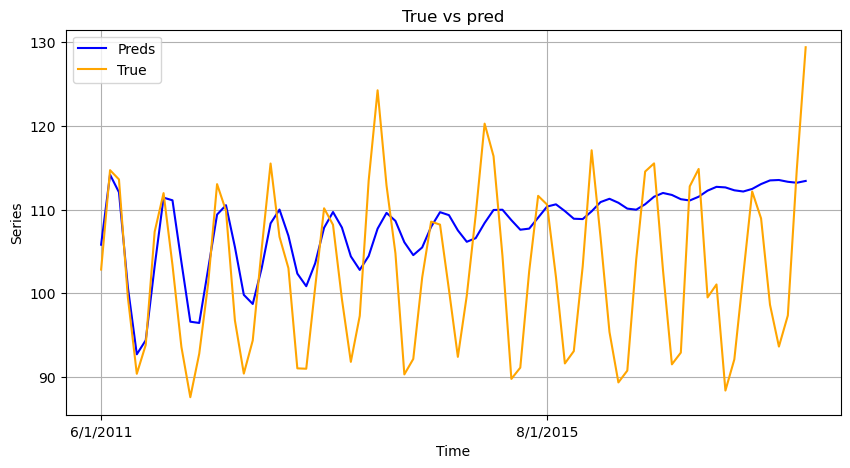

In [59]:
plot_comparison(time_valid, series_valid, preds_model_1)

We can see that our predictions start well, but then, as time goes by, they get worse and worse.

<a name="5.2"></a>
### <font color='#2874a6'> <b> 5.2. RNNs </font> </b>

As mentioned in the documentation, SimpleRNN layers expect a 3-dimensional tensor input with the shape **[batch, timesteps, number of features]**. With that, you need to reshape your window from (64, 7) to (64, 7, 1). This means the 7 datapoints in the window will be mapped to 7 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using Lambda layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the input_shape, you can specify None if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to window_size as shown below if you want to set the timesteps dimension to the expected size of your data windows.


<img src="images/model2.png"/>

In [69]:
def build_compile_model_two(name, horizon=G.HORIZON, window_size=G.WINDOW_SIZE):
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window_size]),
                        # if we want to be more flexible, we can write input_shape=[None]
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(horizon),
        tf.keras.layers.Lambda(lambda x: x*100.0) # scaling to around the same figure as your labels
    ], name=name) 
    
    
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mse"]) 

    return model


model_2 = build_compile_model_two('LSTM_Model')
model_2.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 7, 1)              0         
                                                                 
 bidirectional (Bidirection  (None, 7, 256)            133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 297601 (1.14 MB)
Trainable params: 297601 

In [73]:
# Fit the model
history_2 = model_2.fit(
            train_set,
            epochs=100,
            verbose=0,
            batch_size=G.BATCH_SIZE,
            validation_data=val_set)

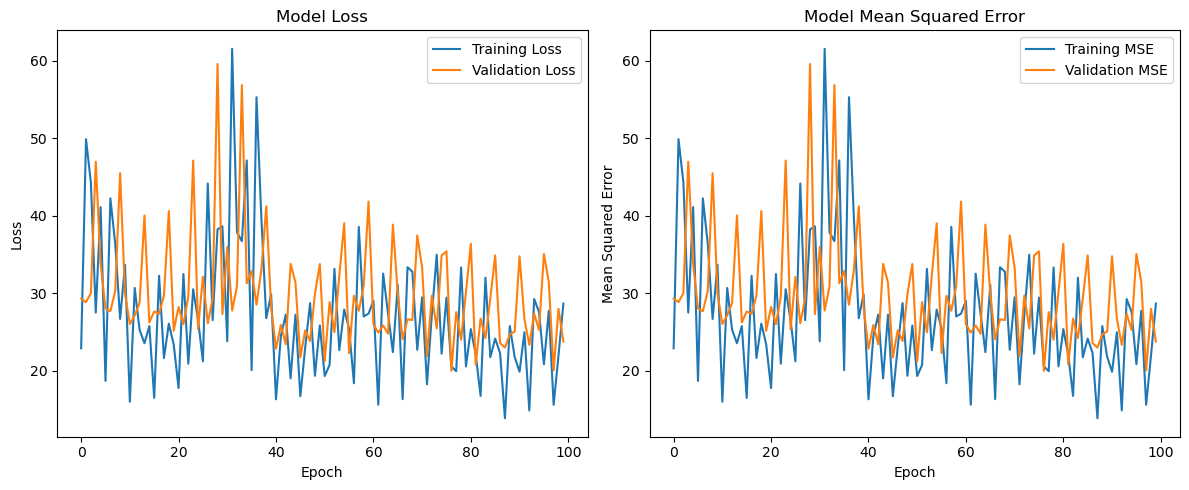

In [139]:
plot_history(history_2)

In [74]:
preds_model_2 = forecast(model_2, series_train[-G.WINDOW_SIZE:], len(series_valid))

In [76]:
preds_model_2.shape

(80,)

In [77]:
model_2_results = evaluate_preds(series_valid, preds_model_2)
model_2_results

{'mae': 8.105601, 'mse': 95.93895, 'rmse': 9.794843, 'mape': 8.159448}

In [112]:
store_results(results, 'Model 2: LSTM', model_2_results);

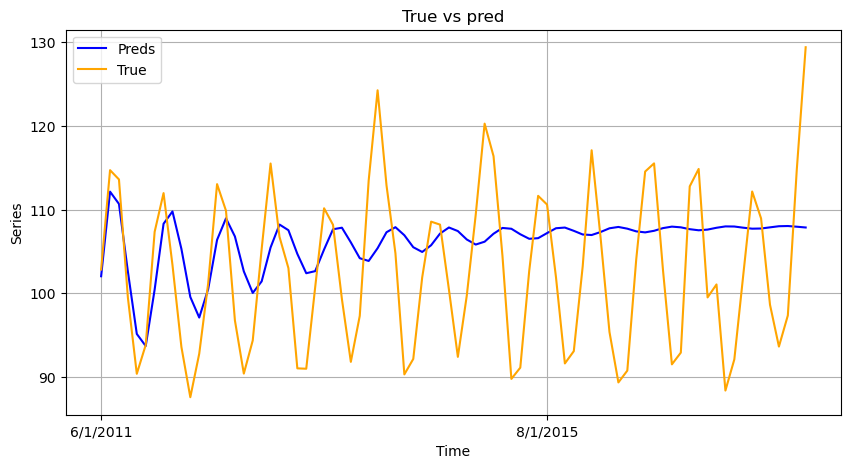

In [113]:
plot_comparison(time_valid, series_valid, preds_model_2)

<a name="6"></a>
## <font color='#1a5276'> <b> 6. Comparing results </font> </b>

In [115]:
# Convert dictionary to DataFrame
df_metrics = pd.DataFrame(results).T  # .T transposes the DataFrame for easier viewing
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
df_metrics

,Model,mae,mse,rmse,mape
0,Naive Forecast,8.326281,90.360390,9.505808,8.093309
1,Model 1 (Simple Dense),8.078486,105.330322,10.263056,8.246225
2,Model 2: LSTM,8.105601,95.938950,9.794843,8.159448


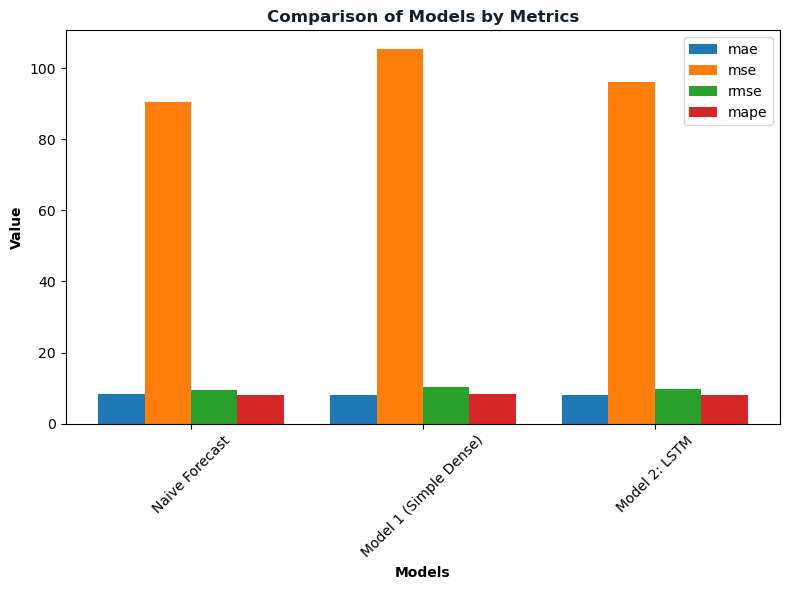

In [127]:
# Let's plot  
plot_model_metrics(results)

Except for MAE, the Naive Forecast yields the best results across the other metrics (MSE, RMSE, and MAPE). However, with some hyperparameter tuning, we may be able to achieve better performance with the other models.

<a name="7"></a>
## <font color='#1a5276'> <b> 7. Hyperparameter Tuning </font> </b>

In [217]:
class MyHyperModel(keras_tuner.HyperModel) :
     def build(self, hp, horizon=G.HORIZON, window_size=G.WINDOW_SIZE):
            
            
        # Define input layer
        inputs = layers.Input(shape=[window_size]) # (window_size, )

        # Dense layer with a fixed number of units
        dense_layer = layers.Dense(hp.Choice('number_neurons',[32, 64, 96, 128, 256, 512]), 
                                   activation='relu')(inputs)
        

        # Output layer
        outputs = layers.Dense(horizon, activation="linear")(dense_layer)

        # Create the model
        #model = models.Model(inputs=inputs, outputs=outputs)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compile the model
        model.compile(optimizer=hp.Choice('optim',['adam','adamax']),
                      loss='mse',
                      metrics = ['mse'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
                    
        return model

In [218]:
tuner = kt.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_mse",
                        max_trials = 10,
                        overwrite=True,
                        directory='search_dir',
                        project_name='electrical_prod_forecasting')

In [219]:
tuner.search(x=train_set, epochs=50,
             validation_data=val_set)

Trial 10 Complete [00h 00m 05s]
val_mse: 21.157302856445312

Best val_mse So Far: 21.157302856445312
Total elapsed time: 00h 00m 50s


In [220]:
tuner.results_summary(1)

Results summary
Results in search_dir/electrical_prod_forecasting
Showing 1 best trials
Objective(name="val_mse", direction="min")

Trial 09 summary
Hyperparameters:
number_neurons: 512
optim: adam
lr: 0.01
Score: 21.157302856445312


In [221]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 512)               4096      
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [222]:
"""
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]
"""

history = model.fit(
                  train_set, 
                  validation_data=val_set,
                  epochs=100, 
                  verbose=0,
                  batch_size=G.BATCH_SIZE)                  
                  #callbacks=callbacks)

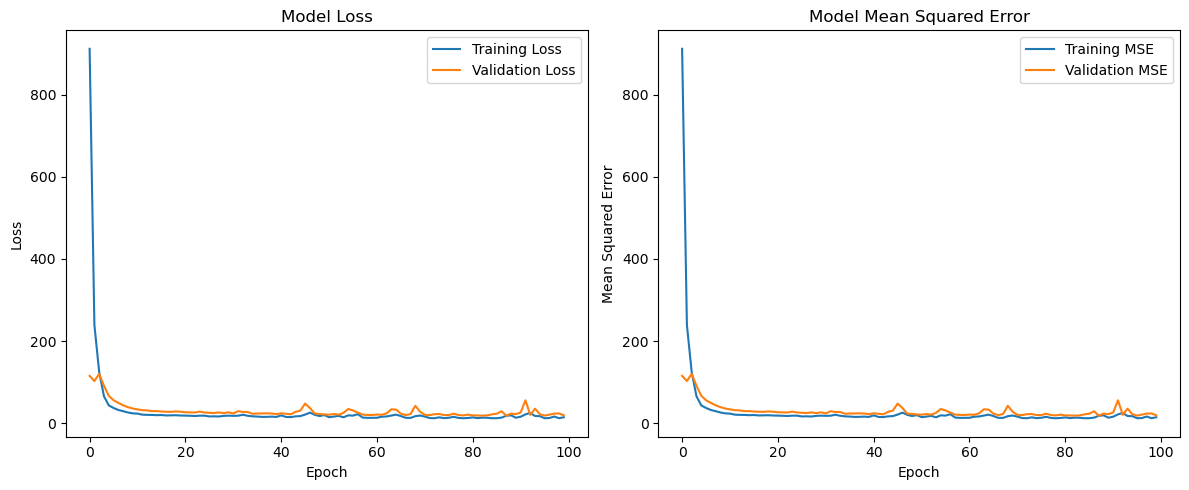

In [223]:
plot_history(history)

In [224]:
preds_model = forecast(model, series_train[-G.WINDOW_SIZE:], len(series_valid))

model_results = evaluate_preds(series_valid, preds_model)

In [225]:
model_results

{'mae': 7.0546618, 'mse': 81.09955, 'rmse': 9.005528, 'mape': 6.5566483}

In [226]:
naive_results

{'mae': 8.326281, 'mse': 90.36039, 'rmse': 9.505808, 'mape': 8.093309}

Great! We beat the Naive Forecast.

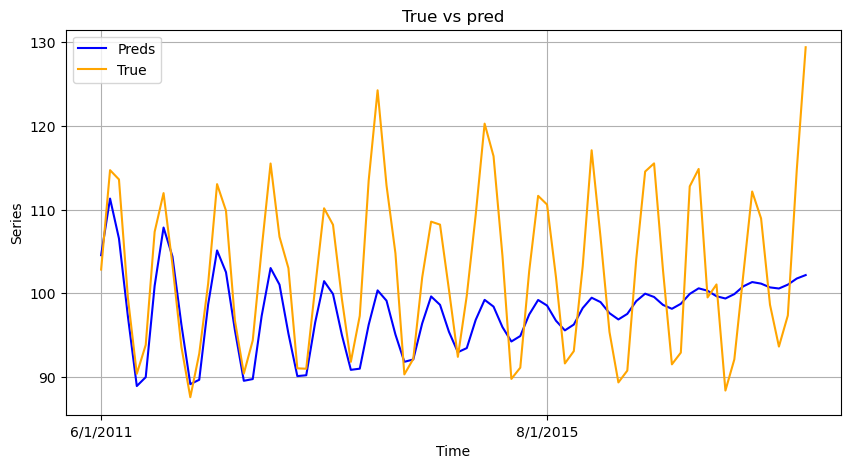

In [227]:
plot_comparison(time_valid, series_valid, preds_model)

<a name="References"></a>
## <font color='#1a5276'> <b> 8. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)

